# Quantifying Home-Country Preference in Figure Skating Scores

The International Skating Union introduced anonymous judging as part of sweeping reforms following the 2002 Olympics. The ISU voted to reverse that policy before the start of the 2016-17 figure skating season, meaning that it is possible to know the scores provided by each judge. This analysis uses scoring data from every major international competition from October 2016 through December 2017 to quantify judges' home-country preference.

In [1]:
import pandas as pd
from scipy import stats
import matplotlib
%matplotlib inline

## Load Judge and Score Data

In [2]:
all_judges = pd.read_csv("../data/processed/judges.csv")
all_judges.head()

,judge_name,assigned_country,role,segment_category,pdf_name,program,competition,officials_table_link,results_pdf_link,clean_judge_name
0,Ms. Chihee RHEE,KOR,Judge No.1,Free Dance|Ice Dance,4f3031488c_data0405.pdf,ICE DANCE FREE DANCE,Grand Prix Final 2017 Senior and Junior,http://www.isuresults.com/results/season1718/g...,http://www.isuresults.com/results/season1718/g...,Chihee RHEE
1,Mr. David MUNOZ,ESP,Judge No.2,Free Dance|Ice Dance,4f3031488c_data0405.pdf,ICE DANCE FREE DANCE,Grand Prix Final 2017 Senior and Junior,http://www.isuresults.com/results/season1718/g...,http://www.isuresults.com/results/season1718/g...,David MUNOZ
2,Mr. Feng HUANG,CHN,Judge No.3,Free Dance|Ice Dance,4f3031488c_data0405.pdf,ICE DANCE FREE DANCE,Grand Prix Final 2017 Senior and Junior,http://www.isuresults.com/results/season1718/g...,http://www.isuresults.com/results/season1718/g...,Feng HUANG
3,Mr. Richard DALLEY,USA,Judge No.4,Free Dance|Ice Dance,4f3031488c_data0405.pdf,ICE DANCE FREE DANCE,Grand Prix Final 2017 Senior and Junior,http://www.isuresults.com/results/season1718/g...,http://www.isuresults.com/results/season1718/g...,Richard DALLEY
4,Mr. Walter ZUCCARO,ITA,Judge No.5,Free Dance|Ice Dance,4f3031488c_data0405.pdf,ICE DANCE FREE DANCE,Grand Prix Final 2017 Senior and Junior,http://www.isuresults.com/results/season1718/g...,http://www.isuresults.com/results/season1718/g...,Walter ZUCCARO


In [3]:
judge_nat = pd.read_csv("../data/processed/judge-country.csv")
judge_nat.head()

,clean_judge_name,judge_country
0,Adriana DOMANSKA,SVK
1,Adriana ORDEANU,ROU
2,Agita ABELE,LAT
3,Agnieszka SWIDERSKA,POL
4,Aigul KUANISHEVA,KAZ


In [4]:
judges = pd.merge(
    all_judges,
    judge_nat,
    on="clean_judge_name"
)

The ISU's results pages list judge roles with a full description, e.g., **Judge No. 1**. In the protocol PDFs that the ISU releases after each competition, the judge number is reduced to a shorter description, e.g., **J1**. The function below converts the longer description to the shorter description found in the PDF.

In [5]:
def clean_judge_number(role):
    return "J" + role.strip()[-1]

In [6]:
judges["clean_role"] = judges["role"].apply(clean_judge_number)

In [7]:
judges["clean_role"].value_counts().sort_index()

J1    152
J2    152
J3    152
J4    152
J5    152
J6    151
J7    152
J8    152
J9    152
Name: clean_role, dtype: int64

### Load scoring data

See this repository's `README.md` file for more details about the source and structure of the scoring data.

In [8]:
performances = pd.read_csv("../data/raw/performances.csv")
print("{:,} performances".format(len(performances)))

aspects = pd.read_csv("../data/raw/judged-aspects.csv")
print("{:,} aspects".format(len(aspects)))

scores = pd.read_csv("../data/raw/judge-scores.csv")
print("{:,} scores".format(len(scores)))

1,726 performances
23,932 aspects
214,531 scores


In [9]:
performances.head()

,performance_id,competition,program,name,nation,rank,starting_number,total_segment_score,total_element_score,total_component_score,total_deductions
0,6e4bd41ac5,Grand Prix Final 2017 Senior and Junior,ICE DANCE FREE DANCE,Anna CAPPELLINI / Luca LANOTTE,ITA,5,1,110.99,56.01,54.98,0.0
1,562c01c5a6,Grand Prix Final 2017 Senior and Junior,ICE DANCE FREE DANCE,Madison HUBBELL / Zachary DONOHUE,USA,4,2,112.59,57.42,55.17,0.0
2,2de894c029,Grand Prix Final 2017 Senior and Junior,ICE DANCE FREE DANCE,Madison CHOCK / Evan BATES,USA,3,3,112.79,57.25,55.54,0.0
3,06e4b8b67e,Grand Prix Final 2017 Senior and Junior,ICE DANCE FREE DANCE,Maia SHIBUTANI / Alex SHIBUTANI,USA,6,4,109.91,54.15,55.76,0.0
4,72e3228deb,Grand Prix Final 2017 Senior and Junior,ICE DANCE FREE DANCE,Tessa VIRTUE / Scott MOIR,CAN,2,5,118.33,59.66,58.67,0.0


In [10]:
aspects.head()

,aspect_id,performance_id,section,aspect_num,aspect_desc,info_flag,credit_flag,base_value,factor,goe,ref,scores_of_panel
0,00034b9414,b639d77459,components,NaN,Transitions,NaN,NaN,NaN,0.8,NaN,NaN,9.07
1,0004dd08d6,9589bb2ebf,components,NaN,Transitions,NaN,NaN,NaN,0.8,NaN,NaN,6.64
2,000b8b5070,71d2b1b597,components,NaN,Performance,NaN,NaN,NaN,1.0,NaN,NaN,7.68
3,000cec97c9,41a2345881,components,NaN,Transitions,NaN,NaN,NaN,0.8,NaN,NaN,4.71
4,000df5399a,b017147b2f,elements,1.0,3Tw2,NaN,NaN,5.8,NaN,-0.2,NaN,5.60


In [11]:
scores.head()

,aspect_id,judge,score
0,00034b9414,J1,9.00
1,00034b9414,J2,9.00
2,00034b9414,J3,8.75
3,00034b9414,J4,9.25
4,00034b9414,J5,9.00


In [12]:
judge_goe = pd.read_csv("../data/processed/judge-goe.csv")
judge_goe.head()

,aspect_id,judge,judge_goe
0,000df5399a,J1,-0.7
1,000df5399a,J2,-0.7
2,000df5399a,J3,-0.7
3,000df5399a,J4,0.0
4,000df5399a,J5,-0.7


In [13]:
scores_with_context = scores.pipe(
    pd.merge,
    aspects,
    on = "aspect_id",
    how = "left"
).pipe(
    pd.merge,
    performances,
    on = "performance_id",
    how = "left"
).pipe(
    pd.merge,
    judge_goe,
    on = [ "aspect_id", "judge" ],
    how = "left"
).assign(
    is_junior = lambda x: x["program"].str.contains("JUNIOR"),
    program_type = lambda x: x["program"]\
        .apply(lambda x: "short" if "SHORT" in x else "free")
)

In [14]:
assert len(scores) == len(scores_with_context)

Here, we remove junior programs from the data, so that we're only analyzing senior performances. (There are both junior and senior programs at the Grand Prix Finals.)

In [15]:
senior_scores = scores_with_context[
    scores_with_context["is_junior"] == False
].copy()

senior_scores["performance_id"].nunique()

1632

In [16]:
senior_scores.tail().T

,214526,214527,214528,214529,214530
aspect_id,fff81cacfb,fff81cacfb,fff81cacfb,fff81cacfb,fff81cacfb
judge,J5,J6,J7,J8,J9
score,1,1,2,2,2
performance_id,ba47e4e8f3,ba47e4e8f3,ba47e4e8f3,ba47e4e8f3,ba47e4e8f3
section,elements,elements,elements,elements,elements
aspect_num,2,2,2,2,2
aspect_desc,1MB4+kpYYY,1MB4+kpYYY,1MB4+kpYYY,1MB4+kpYYY,1MB4+kpYYY
info_flag,NaN,NaN,NaN,NaN,NaN
credit_flag,NaN,NaN,NaN,NaN,NaN
base_value,5,5,5,5,5


## Calculate Total Points for Each Judge and Difference from the Mean

### Calculate the total number of points awarded for each aspect

The total score given by a judge is calculated differently for elements vs. components. Technical elements are scored by adding the base value of the element to the translated Grade of Execution. Artistic components are scored by multiplying the score the judge gave by a pre-determined factor. The function below does this math for both sections of each program.

In [17]:
def total_points(row):
    # In one edge-case, a "J6" is listed as providing a score of zero.
    # (There was no sixth judge, and the minimum score for a component is 0.25, per ISU regulations.)
    # In the if-clause below, we ignore this edge-case.
    if (row["section"] == "components") and (row["score"] == 0):
        return None
    
    elif row["section"] == "elements":
        return round(row["base_value"] + row["judge_goe"], 2)
    
    elif row["section"] == "components":
        return round(row["factor"] * row["score"], 2)
    
    else:
        print("Unknown section: {}".format(row["section"]))
        return None

In [18]:
senior_scores["total_points"] = senior_scores.apply(total_points, axis=1)

### Calculate the total number of points awarded for each performance by each judge


After calculating the total points awarded for each aspect, it is possible to calculate the total score that a skater would have received from any individual judge. Points can be deducted from the final score for falls or other problems. These deductions are issued by the technical panel and are not the purview of any individual judge; still, we subtract them from the final score to get an accurate representation of how a judge scored the overall skate.

In [19]:
perf_judge_grps = senior_scores[
    ~senior_scores["total_points"].isnull()
].groupby(["performance_id", "judge"])

In [20]:
points_by_judge = pd.DataFrame({
    "points": perf_judge_grps["total_points"].sum(),
    "deductions": perf_judge_grps["total_deductions"].first(),
    "name": perf_judge_grps["name"].first(),
    "nation": perf_judge_grps["nation"].first(),
    "program": perf_judge_grps["program"].first(),
    "program_type": perf_judge_grps["program_type"].first(),
    "competition": perf_judge_grps["competition"].first()
}).reset_index()
points_by_judge["final_score"] = points_by_judge["points"] - points_by_judge["deductions"]

points_by_judge.head()

,performance_id,judge,competition,deductions,name,nation,points,program,program_type,final_score
0,0055dd827d,J1,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,176.58,MEN FREE SKATING,free,176.58
1,0055dd827d,J2,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,174.28,MEN FREE SKATING,free,174.28
2,0055dd827d,J3,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,185.88,MEN FREE SKATING,free,185.88
3,0055dd827d,J4,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,183.78,MEN FREE SKATING,free,183.78
4,0055dd827d,J5,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,178.28,MEN FREE SKATING,free,178.28


In [21]:
print("Deductions occur in about {:.0f}% of scores:"\
    .format((points_by_judge["deductions"] > 0).mean() * 100))

points_by_judge["deductions"].astype(int).value_counts()

Deductions occur in about 30% of scores:


0    10253
1     3419
2      846
4       72
3       63
6       18
9        9
Name: deductions, dtype: int64

### Calculate the total number of points awarded for each performance

In [22]:
perf_grps = points_by_judge.groupby(["performance_id"])

In [23]:
perfs = pd.DataFrame({
    "total_points": perf_grps["final_score"].sum(),
    "total_judges": perf_grps.size()
}).reset_index()

perfs.head()

,performance_id,total_judges,total_points
0,0055dd827d,9,1615.52
1,00693b66b5,9,689.20
2,007541009f,9,930.10
3,007e8ef343,9,529.40
4,008085d237,9,1476.57


In [24]:
points_with_comparison = pd.merge(
    points_by_judge,
    perfs,
    how = "left",
    on = "performance_id"
)

points_with_comparison.head()

,performance_id,judge,competition,deductions,name,nation,points,program,program_type,final_score,total_judges,total_points
0,0055dd827d,J1,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,176.58,MEN FREE SKATING,free,176.58,9,1615.52
1,0055dd827d,J2,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,174.28,MEN FREE SKATING,free,174.28,9,1615.52
2,0055dd827d,J3,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,185.88,MEN FREE SKATING,free,185.88,9,1615.52
3,0055dd827d,J4,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,183.78,MEN FREE SKATING,free,183.78,9,1615.52
4,0055dd827d,J5,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,178.28,MEN FREE SKATING,free,178.28,9,1615.52


### Calculate the average points for each performance, excluding the given judge

`points_vs_avg` is the total number of points a judge scored the performance above or below the average score of all the remaining judges for that particular performance. It is the comparison point that we will use in all of the analyses moving forward.

In [25]:
points_with_comparison["avg_without_judge"] = points_with_comparison\
    .apply(lambda x: (x["total_points"] - x["final_score"]) / (x["total_judges"] - 1), axis=1)

In [26]:
points_with_comparison["points_vs_avg"] = points_with_comparison["final_score"] - \
    points_with_comparison["avg_without_judge"]

## Merge Judge Data with Score Data

In [27]:
judge_points = pd.merge(
    points_with_comparison,
    judges[[
        "program", "competition", "segment_category",
        "clean_judge_name", "judge_country", "clean_role"
    ]],
    left_on=[ "program", "competition", "judge" ],
    right_on=[ "program", "competition", "clean_role" ],
    how="left"
).dropna(subset=["judge_country"])

judge_points.head()

,performance_id,judge,competition,deductions,name,nation,points,program,program_type,final_score,total_judges,total_points,avg_without_judge,points_vs_avg,segment_category,clean_judge_name,judge_country,clean_role
0,0055dd827d,J1,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,176.58,MEN FREE SKATING,free,176.58,9,1615.52,179.8675,-3.2875,Free Skating|Men,Francoise DE RAPPARD,BEL,J1
1,0055dd827d,J2,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,174.28,MEN FREE SKATING,free,174.28,9,1615.52,180.1550,-5.8750,Free Skating|Men,Masako KUBOTA,JPN,J2
2,0055dd827d,J3,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,185.88,MEN FREE SKATING,free,185.88,9,1615.52,178.7050,7.1750,Free Skating|Men,Yuri GUSKOV,KAZ,J3
3,0055dd827d,J4,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,183.78,MEN FREE SKATING,free,183.78,9,1615.52,178.9675,4.8125,Free Skating|Men,Saodat NUMANOVA,UZB,J4
4,0055dd827d,J5,ISU GP Trophee de France 2016,0.0,Denis TEN,KAZ,178.28,MEN FREE SKATING,free,178.28,9,1615.52,179.6550,-1.3750,Free Skating|Men,Elisabeth LOUESDON,FRA,J5


In [28]:
judge_points["skater_judge_same_country"] = (judge_points["nation"] == judge_points["judge_country"])

In [29]:
print("""
In the dataset, there are {:,} performance-judge combinations 
in which the judge and skater(s) represent the *same* country.

There are {:,} performance-judge combinations in which the 
judge and skater(s) represent *different* countries.
""".format(
    judge_points["skater_judge_same_country"].sum(),
  (~judge_points["skater_judge_same_country"]).sum()
))


In the dataset, there are 1,305 performance-judge combinations 
in which the judge and skater(s) represent the *same* country.

There are 13,375 performance-judge combinations in which the 
judge and skater(s) represent *different* countries.



# Calculate Home-Country Preference

## Account for judge "generosity" by program type

One reason that home-country preferences among groups of judges — e.g., all judges overall or for all judges representing an entire country — might appear is if the most generous-grading judges are over-represented among home-country judgements. Additionally, the range in scores is larger for "free" programs than "short" programs. So, below, we adjust each judge's "points versus the average" to account for their overall tendency to give scores higher or lower than the average, for both the free and short programs. Note: These calculations are *not* used for evaluating individual judges.

In [30]:
judge_means = judge_points.groupby(["clean_judge_name", "program_type"])\
    ["points_vs_avg"].mean()\
    .to_frame()\
    .reset_index()

judge_means.head()

,clean_judge_name,program_type,points_vs_avg
0,Adriana DOMANSKA,free,1.944444
1,Adriana DOMANSKA,short,0.452632
2,Agita ABELE,free,1.068632
3,Agita ABELE,short,0.928748
4,Agnieszka SWIDERSKA,short,1.217361


In [31]:
judge_points_with_means = pd.merge(
    judge_points,
    judge_means,
    on = [ "clean_judge_name", "program_type" ],
    how = "left",
    suffixes = [ "_overall", "_mean" ]
)

In [32]:
judge_points_with_means["points_vs_avg_adj"] = \
    judge_points_with_means["points_vs_avg_overall"] - \
    judge_points_with_means["points_vs_avg_mean"]
    
judge_points_with_means[[
    "performance_id",
    "judge",
    "avg_without_judge",
    "final_score",
    "points_vs_avg_overall",
    "points_vs_avg_mean",
    "points_vs_avg_adj"
    
]].head()

,performance_id,judge,avg_without_judge,final_score,points_vs_avg_overall,points_vs_avg_mean,points_vs_avg_adj
0,0055dd827d,J1,179.8675,176.58,-3.2875,-0.058263,-3.229237
1,0055dd827d,J2,180.1550,174.28,-5.8750,0.976538,-6.851538
2,0055dd827d,J3,178.7050,185.88,7.1750,1.103922,6.071078
3,0055dd827d,J4,178.9675,183.78,4.8125,1.767614,3.044886
4,0055dd827d,J5,179.6550,178.28,-1.3750,0.547807,-1.922807


## Calculate Overall Home-Country Preference

To examine whether an overall home-country preference exists in figure skating, we compare the scores given by judges to skaters from their own country to those they give skaters from other countries. Then we use a t-test to determine whether this difference is statistically significant. (It is.) Finally, we then show this preference graphically.

In [33]:
judge_points_with_means["skater_judge_same_country"].value_counts()

False    13375
True      1305
Name: skater_judge_same_country, dtype: int64

In [34]:
overall_point_diffs = judge_points_with_means\
    .groupby("skater_judge_same_country")["points_vs_avg_adj"]\
    .mean()

print((
    "- Same-country point difference: {:.3f}\n"
    "- Other-country point difference: {:.3f}\n"
    "- Overall same-country preference: {:.1f}"
).format(
    overall_point_diffs[True],
    overall_point_diffs[False],
    overall_point_diffs[True] - overall_point_diffs[False]
))

- Same-country point difference: 3.088
- Other-country point difference: -0.301
- Overall same-country preference: 3.4


In [35]:
stats.ttest_ind(
    judge_points_with_means[
        judge_points_with_means["skater_judge_same_country"]
    ]["points_vs_avg_adj"],
    
    judge_points_with_means[
        ~judge_points_with_means["skater_judge_same_country"]
    ]["points_vs_avg_adj"],
    
    equal_var = False
)

Ttest_indResult(statistic=37.859765344104062, pvalue=5.1762242757333122e-225)

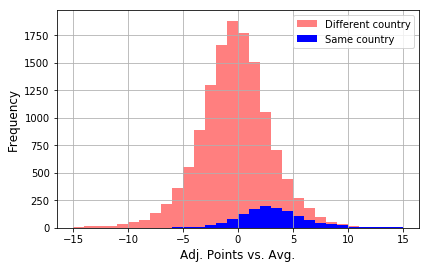

In [36]:
judge_points_with_means[
    ~judge_points_with_means["skater_judge_same_country"]
]["points_vs_avg_adj"].hist(
    color = "red", 
    alpha = 0.5,
    bins = 30,
    range = (-15, 15),
    label = "Different country",
    figsize = (6.5, 4)
)
    
judge_points_with_means[
    judge_points_with_means["skater_judge_same_country"]
]["points_vs_avg_adj"].hist(
    color = "blue", 
    alpha = 1,
    bins = 30,
    range = (-15, 15),
    label = "Same country"
)
    
matplotlib.pyplot.legend(loc = "upper right")
matplotlib.pyplot.xlabel(
    "Adj. Points vs. Avg.",
    fontsize = 12
)

matplotlib.pyplot.ylabel(
    "Frequency",
    fontsize = 12
)
pass

## Calculate Preference by Program Type

In [37]:
preference_by_program = judge_points_with_means\
    .groupby(["program", "skater_judge_same_country"])["points_vs_avg_adj"]\
    .mean()\
    .unstack()
    
preference_by_program["preference"] = preference_by_program[True] - \
    preference_by_program[False]

preference_by_program.sort_values("preference", ascending=False)

skater_judge_same_country,False,True,preference
program,,,
ICE DANCE FREE DANCE,-0.338288,4.420223,4.758511
MEN FREE SKATING,-0.589990,4.059068,4.649057
PAIRS FREE SKATING,-0.225747,3.870366,4.096113
LADIES FREE SKATING,-0.379200,3.536831,3.916031
ICE DANCE SHORT DANCE,-0.247323,2.659254,2.906576
PAIRS SHORT PROGRAM,-0.231820,2.333422,2.565242
MEN SHORT PROGRAM,-0.182066,2.048338,2.230404
LADIES SHORT PROGRAM,-0.204828,2.008169,2.212998


## Calculate Preference by Country

This analysis repeats the approach above to calculate home-country preference on a per-country basis. The results are limited to countries with at least 50 home-country judgments in the dataset.

In [38]:
country_grps = judge_points_with_means.groupby("judge_country")

In [39]:
country_df = pd.DataFrame({
    "total_performances": country_grps.size(),
    
    "same_performances": country_grps.apply(lambda x: len(x[x["skater_judge_same_country"]])),
    
    "avg_null_preference": country_grps.apply(lambda x: x[
            ~x["skater_judge_same_country"]
        ]["points_vs_avg_adj"].mean()),
    
    "avg_same_preference": country_grps.apply(lambda x: x[
            x["skater_judge_same_country"]
        ]["points_vs_avg_adj"].mean())
})

In [40]:
country_df["preference"] = round(country_df["avg_same_preference"] - country_df["avg_null_preference"], 2)

In [41]:
country_df[
    country_df["same_performances"] >= 50
].sort_values("preference", ascending=False)

,avg_null_preference,avg_same_preference,same_performances,total_performances,preference
judge_country,,,,,
CHN,-0.583526,4.005107,110,865,4.59
ITA,-0.313215,3.829301,62,820,4.14
RUS,-0.697527,3.249981,226,1279,3.95
USA,-0.634052,2.857386,229,1261,3.49
CAN,-0.478310,2.996869,177,1286,3.48
FRA,-0.277991,2.381595,67,641,2.66
JPN,-0.329839,2.030642,147,1052,2.36


## Analyze Preferences of Individual Judges

Some judges have only a handful of instances where they judge skaters from their same country. This fact could skew the t-test calculation, so instead here we use statistical simulations to quantify the probability of a judge showing as much home-country preference as we see in the data.

To perform those simulations, we calculate the judge's actual home-country preference and then compare it to the home-country preferences derived by assigning all of the judge's score differences to home-country or non-home-country skaters at random. For each judge, we repeat the simulation 1 million times, and then check how often the simulated scoring preference equals or exceeds the actual home-country preference. This provides an estimated probability of such home-country preference (or stronger) occurring by chance alone.

In [42]:
import random
import numpy as np

In [43]:
def shuffle_and_find_diff_by_program_length(
        score_diffs_short, 
        score_diffs_free, 
        count_same_country_short, 
        count_same_country_free):
    random.shuffle(score_diffs_short)
    random.shuffle(score_diffs_free)
    same_country_diffs = score_diffs_short[:count_same_country_short] + \
        score_diffs_free[:count_same_country_free]
    other_country_diffs = score_diffs_short[count_same_country_short:] + \
        score_diffs_free[count_same_country_free:]
    return np.mean(same_country_diffs) - np.mean(other_country_diffs)

In [44]:
def find_judge_prob(row, runs=1000000):
    if row["num_same_as_skater"] == 0:
        return None
    else:
        score_diffs_short = list(judge_points[
            (judge_points["clean_judge_name"] == row["clean_judge_name"]) &
            (judge_points["program_type"] == "short")
        ]["points_vs_avg"])
        score_diffs_free = list(judge_points[
            (judge_points["clean_judge_name"] == row["clean_judge_name"]) &
            (judge_points["program_type"] == "free")
        ]["points_vs_avg"])
        overall_preference = row["avg_same_preference"] - row["avg_null_preference"]
        calc_prefs = [ shuffle_and_find_diff_by_program_length(
                         score_diffs_short, 
                         score_diffs_free, 
                         int(row["num_same_as_skater_short"]), 
                         int(row["num_same_as_skater_free"])) 
                      for i in range(runs) ]
        return len([ cb for cb in calc_prefs if cb >= overall_preference ]) / runs

In [45]:
judge_grps = judge_points.groupby(["clean_judge_name"])

In [46]:
len(judge_grps)

214

In [47]:
judged_by_judge = pd.DataFrame({
    "country": judge_grps["judge_country"].first(),
    
    "total": judge_grps.size(),
    
    "num_same_as_skater": judge_grps["skater_judge_same_country"].sum(),
    
    "num_same_as_skater_short": judge_grps\
        .apply(lambda x: x[
            x["program_type"] == "short"
        ]["skater_judge_same_country"].sum()),
    
    "num_same_as_skater_free": judge_grps\
        .apply(lambda x: x[
            x["program_type"] == "free"
        ]["skater_judge_same_country"].sum()),
    
    "avg_same_preference": judge_grps.apply(lambda x: x[
        x["skater_judge_same_country"]
    ]["points_vs_avg"].mean()),
    
    "avg_null_preference": judge_grps.apply(lambda x: x[
        ~x["skater_judge_same_country"]
    ]["points_vs_avg"].mean())
}).reset_index()

In [48]:
judged_by_judge["bootstrapped"] = judged_by_judge.apply(find_judge_prob, axis=1)

In [49]:
judged_by_judge["preference"] = round(judged_by_judge["avg_same_preference"] - \
    judged_by_judge["avg_null_preference"], 3)

In [50]:
low_prob_judges = judged_by_judge[
    # We are using a conservative cutoff and looking for 
    # judges with a probability of less than 1 in 100,000
    (judged_by_judge["bootstrapped"] < 0.00001)
]

**Important Note:**

Higher home-country scores do not in and of themselves show a judge is deliberately trying to raise a compatriot’s standing; the scores could reflect a preference for a regional style of skating, for example, or an inclination toward skaters the judge has taken special note of, or even just patriotism. Judges might not even be aware that they consistently up-score their compatriots.

BuzzFeed News reached out to all 27 judges below for comment through their national federations, as well as to the individual judges themselves by phone, email, Facebook, or messages left at work. The US and Chinese skating federations declined to comment.

Most of the judges either did not respond to messages or chose not to speak on the record. Two judges did provide comment:

- Walter Toigo told BuzzFeed News, “Everybody has a different opinion and we judge what we can see." He added, "We are human beings, not machines. I judge what I think. I try to be consistent with all the skaters.”

- Igor Dolgushin told BuzzFeed News, “I'm a judge and signed the Ethics Code for Judges, and I judge fairly and adequately in all tournaments.”

In an email, a spokesperson for Skate Canada told BuzzFeed News that “all of the Canadian judges submitted to the ISU for the PyeongChang 2018 Olympic Winter Games meet the eligibility criteria, and were approved as judges by the ISU, according to its rules and regulations.” A representative of the Figure Skating Federation of Russia declined to answer questions and said, “None of our judges want to comment.”

In [51]:
low_prob_judges.sort_values(["preference"], ascending=False)

,clean_judge_name,avg_null_preference,avg_same_preference,country,num_same_as_skater,num_same_as_skater_free,num_same_as_skater_short,total,bootstrapped,preference
202,Walter TOIGO,-2.548090,4.947917,ITA,6.0,3,3,114,0.000000,7.496
83,Jeff LUKASIK,-2.072679,4.982031,CAN,16.0,9,7,121,0.000000,7.055
19,Anna KANTOR,-0.935775,5.795139,ISR,9.0,4,5,230,0.000000,6.731
15,Andrea DERBY,-2.018750,4.251250,CAN,10.0,5,5,50,0.000000,6.270
9,Alexei BELETSKI,-0.091558,6.149219,ISR,8.0,4,4,162,0.000001,6.241
33,Cynthia BENSON,-2.277138,3.907292,CAN,12.0,6,6,88,0.000000,6.184
187,Tanay OZKAN,0.284358,6.362500,TUR,9.0,4,5,188,0.000000,6.078
73,Igor DOLGUSHIN,0.521412,6.306250,RUS,12.0,6,6,66,0.000000,5.785
205,Weiguang CHEN,-0.609547,5.152841,CHN,22.0,11,11,204,0.000000,5.762
79,Isabella MICHELI,-1.124351,4.548611,ITA,9.0,4,5,86,0.000000,5.673


---

---

---